In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from scipy.stats import entropy

In [2]:
data = pd.read_csv('modified_data7.csv', encoding='cp1252')

# 필요없는 피처 날리기
data = data.drop("subbedOutTime", axis=1)
data = data.drop("position", axis=1)
data = data.drop("fantasyScore", axis=1)

# 포지션만 있고 세부 포지션 널값처리
# 'positionStringShort'의 널값이 있는 행 찾기
null_positions = data[data['positionStringShort'].isna()]

# 각 널값에 대해 처리
for index, row in null_positions.iterrows():
    # 현재 널값이 있는 행의 'name' 가져오기
    name = row['name']
    # 해당 'name'을 가진 모든 행에서 'positionStringShort'의 최빈값 찾기
    most_frequent_position = data[data['name'] == name]['positionStringShort'].mode()[0]
    # 널값 채우기
    data.at[index, 'positionStringShort'] = most_frequent_position

data = data.drop("name", axis=1)
# rating 널값 제거, 개수가 매우적어 없는거만 제거
data = data.dropna(subset=["rating"])

# x , y 나누기
data_x = data.drop("rating", axis=1)
data_y = data["rating"]

# 학습, 테스트 데이터 나누기
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2)

# 'positionStringShort'와 'positionRow' 열 선택
x_train_cat = x_train[['positionStringShort', 'positionRow']].values
# OneHotEncoder 객체 생성
cat_encoder = OneHotEncoder()
# 원-핫 인코딩 적용
x_train_cat_1hot = cat_encoder.fit_transform(x_train_cat)
# positionStringShort, positionRow은 카테고리컬
x_train_num = x_train.drop(["positionStringShort", "positionRow"], axis=1)

# 불리언 타입이 아닌 수치형 데이터만 선택
numeric_features = x_train_num.select_dtypes(include=['int64', 'float64'])
# StandardScaler 객체 생성
scaler = StandardScaler()
# 수치형 데이터에 표준화 적용
numeric_features_scaled = scaler.fit_transform(numeric_features)
# 스케일링된 데이터를 데이터프레임으로 변환 (원본 데이터프레임의 인덱스 사용)
numeric_features_scaled_df = pd.DataFrame(numeric_features_scaled, columns=numeric_features.columns,
                                          index=x_train_num.index)
# 데이터를 소수점 셋째 자리에서 반올림
numeric_features_scaled_df = numeric_features_scaled_df.round(3)
# 스케일링된 수치형 데이터프레임을 원본 데이터프레임과 병합
data_num_scaled = x_train_num.copy()
data_num_scaled[numeric_features.columns] = numeric_features_scaled_df

# 원-핫 인코딩된 데이터를 데이터프레임으로 변환
x_train_cat_1hot_df = pd.DataFrame(x_train_cat_1hot.toarray(), columns=cat_encoder.get_feature_names_out(),
                                   index=x_train.index)

# 불리언 타입의 데이터만 선택
bool_features = x_train_num.select_dtypes(include=['bool'])


# 스케일링된 수치형 데이터, 불리언 타입의 데이터, 원-핫 인코딩된 데이터 병합
x_train_prepared = pd.concat([data_num_scaled, bool_features, x_train_cat_1hot_df], axis=1)


In [3]:
# x_test, y_test


# 'positionStringShort'와 'positionRow' 열 선택
x_test_cat = x_test[['positionStringShort', 'positionRow']].values
# OneHotEncoder 객체 생성
cat_encoder2 = OneHotEncoder()
# 원-핫 인코딩 적용
x_test_cat_1hot = cat_encoder2.fit_transform(x_test_cat)

# positionStringShort, positionRow은 카테고리컬
x_test_num = x_test.drop(["positionStringShort", "positionRow"], axis=1)

# 불리언 타입이 아닌 수치형 데이터만 선택
numeric_features2 = x_test_num.select_dtypes(include=['int64', 'float64'])
# StandardScaler 객체 생성
scaler2 = StandardScaler()
# 수치형 데이터에 표준화 적용
numeric_features_scaled2 = scaler.transform(numeric_features2)
# 스케일링된 데이터를 데이터프레임으로 변환 (원본 데이터프레임의 인덱스 사용)
numeric_features_scaled_df2 = pd.DataFrame(numeric_features_scaled2, columns=numeric_features2.columns,
                                          index=x_test_num.index)
# 데이터를 소수점 셋째 자리에서 반올림
numeric_features_scaled_df2 = numeric_features_scaled_df2.round(3)
# 스케일링된 수치형 데이터프레임을 원본 데이터프레임과 병합
data_num_scaled2 = x_test_num.copy()
data_num_scaled2[numeric_features2.columns] = numeric_features_scaled_df2

# 원-핫 인코딩된 데이터를 데이터프레임으로 변환
x_test_cat_1hot_df = pd.DataFrame(x_test_cat_1hot.toarray(), columns=cat_encoder2.get_feature_names_out(),
                                   index=x_test.index)

# 불리언 타입의 데이터만 선택
bool_features2 = x_test_num.select_dtypes(include=['bool'])


# 스케일링된 수치형 데이터, 불리언 타입의 데이터, 원-핫 인코딩된 데이터 병합
x_test_prepared = pd.concat([data_num_scaled2, bool_features2, x_test_cat_1hot_df], axis=1)

In [4]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=3)
tree_reg1.fit(x_train_prepared, y_train)


DecisionTreeRegressor(max_depth=3)

In [5]:
y_train_2 = y_train - tree_reg1.predict(x_train_prepared)

tree_reg2 = DecisionTreeRegressor(max_depth=3)
tree_reg2.fit(x_train_prepared, y_train_2)

DecisionTreeRegressor(max_depth=3)

In [6]:
y_train_3 = y_train_2 - tree_reg2.predict(x_train_prepared)

tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(x_train_prepared, y_train_3)

DecisionTreeRegressor(max_depth=2)

In [7]:
y_train_4 = y_train_3 - tree_reg3.predict(x_train_prepared)

tree_reg4 = DecisionTreeRegressor(max_depth=2)
tree_reg4.fit(x_train_prepared, y_train_4)

DecisionTreeRegressor(max_depth=2)

In [8]:
y_pred3 = sum(tree.predict(x_test_prepared) for tree in (tree_reg1, tree_reg2, tree_reg3))



mse = mean_squared_error(y_test, y_pred3)
rmse = np.sqrt(mse)
print("RMSE_3:", rmse)
# 성능 평가: MAE
mae = mean_absolute_error(y_test, y_pred3)
print("MAE:_3", mae)

print(y_pred3[0:10])
print(y_test[0:10])



RMSE_3: 0.6096319371747837
MAE:_3 0.4484506137547048
[6.64943052 6.86868068 6.86043261 6.86043261 6.86043261 6.34480274
 6.34480274 6.86043261 7.75977147 6.48542987]
1165     5.5
8788     7.1
7875     6.3
10339    7.3
1081     5.6
9634     6.6
6458     6.1
5054     6.3
828      7.9
8064     6.4
Name: rating, dtype: float64


In [9]:
y_pred4 = sum(tree.predict(x_test_prepared) for tree in (tree_reg1, tree_reg2, tree_reg3,tree_reg4))

mse = mean_squared_error(y_test, y_pred4)
rmse = np.sqrt(mse)
print("RMSE_4:", rmse)
# 성능 평가: MAE
mae = mean_absolute_error(y_test, y_pred4)
print("MAE:_4", mae)

print(y_pred4[0:10])
print(y_test[0:10])


RMSE_4: 0.605216140012706
MAE:_4 0.44224316883078957
[6.63410082 6.85335099 6.84510291 6.84510291 6.84510291 6.32947304
 6.23354292 6.74917279 7.74444177 6.47010017]
1165     5.5
8788     7.1
7875     6.3
10339    7.3
1081     5.6
9634     6.6
6458     6.1
5054     6.3
828      7.9
8064     6.4
Name: rating, dtype: float64


In [10]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=4, n_estimators=30, learning_rate=0.5)
gbrt.fit(x_train_prepared, y_train)

GradientBoostingRegressor(learning_rate=0.5, max_depth=4, n_estimators=30)

In [11]:
pred_gbrt = gbrt.predict(x_test_prepared)

mse = mean_squared_error(y_test, pred_gbrt)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
# 성능 평가: MAE
mae = mean_absolute_error(y_test, pred_gbrt)
print("MAE:", mae)

print(pred_gbrt[0:10])
print(y_test[0:10])


RMSE: 0.5578483851292645
MAE: 0.39218844495417793
[6.54003939 6.7366803  7.13778467 7.25788576 6.37984061 5.96182099
 6.01424519 6.81817415 7.84297841 6.69786667]
1165     5.5
8788     7.1
7875     6.3
10339    7.3
1081     5.6
9634     6.6
6458     6.1
5054     6.3
828      7.9
8064     6.4
Name: rating, dtype: float64


In [55]:
param_dist = {
    "max_depth": sp_randint(2, 10),
    "n_estimators": sp_randint(10, 100),
    "learning_rate": sp_uniform(0.01, 0.99)
}
# RandomizedSearchCV 설정
gbrt = GradientBoostingRegressor()
random_search = RandomizedSearchCV(gbrt, param_distributions=param_dist, 
                                   n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42)

# 랜덤 탐색 실행
random_search.fit(x_train_prepared, y_train)

# 결과 평가
print("최적의 파라미터:", random_search.best_params_)
print("최적의 점수:", np.sqrt(-random_search.best_score_))


'''
컴퓨팅 파워가 딸려서 구글 코랩에서 구했다
최적의 파라미터: {'learning_rate': 0.16445845403801215, 'max_depth': 4, 'n_estimators': 96}
최적의 점수: 0.5290512745758192


'''

KeyboardInterrupt: 

In [12]:
gbrt_opt = GradientBoostingRegressor(max_depth=4, n_estimators=96, learning_rate=0.1644584540380121)
gbrt_opt.fit(x_train_prepared, y_train)

pred_gbrt_opt = gbrt_opt.predict(x_test_prepared)

mse = mean_squared_error(y_test, pred_gbrt_opt)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
# 성능 평가: MAE
mae = mean_absolute_error(y_test, pred_gbrt_opt)
print("MAE:", mae)

print(pred_gbrt_opt[0:10])
print(y_test[0:10])


RMSE: 0.541795563722507
MAE: 0.37567321035353246
[6.53686966 6.65803662 7.13719471 6.97541257 6.31139319 5.9919809
 6.03125599 6.84343923 7.91064571 6.56683173]
1165     5.5
8788     7.1
7875     6.3
10339    7.3
1081     5.6
9634     6.6
6458     6.1
5054     6.3
828      7.9
8064     6.4
Name: rating, dtype: float64


7.022101538510572
7.013271320685217


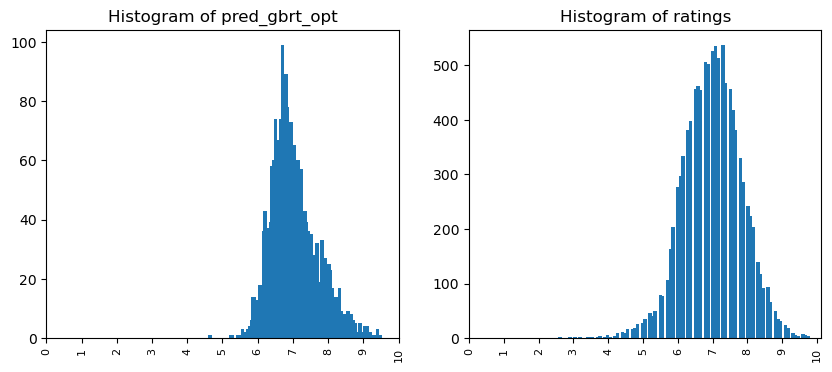

In [14]:
# pred_gbrt_opt에 대한 히스토그램
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(pred_gbrt_opt, bins=100, width=0.1, align='left')
plt.xticks(np.arange(0, 11, 1))
plt.xticks(rotation=90, fontsize=8)
plt.title('Histogram of pred_gbrt_opt')


# target 'rating'에 대한 히스토그램
plt.subplot(1, 2, 2)
plt.hist(data['rating'], bins=100, width=0.1, align='left')
plt.xticks(np.arange(0, 11, 1))
plt.xticks(rotation=90, fontsize=8)
plt.title('Histogram of ratings')

print(pred_gbrt_opt.mean())
print(data['rating'].mean())

In [15]:
# 히스토그램을 확률 분포로 변환
hist1, bin_edges1 = np.histogram(pred_gbrt_opt, bins=30, density=True)
hist2, bin_edges2 = np.histogram(data['rating'], bins=30, density=True)

# 0 값을 가진 히스토그램 bin을 처리 (KL Divergence는 0 로그 불가능)
hist1 = np.where(hist1 == 0, 1e-10, hist1)
hist2 = np.where(hist2 == 0, 1e-10, hist2)

# 쿨백-라이블러 발산 계산
kl_divergence = entropy(hist1, hist2)

kl_divergence


0.6927306734347891

In [13]:

gbrt_test = GradientBoostingRegressor(max_depth=4, n_estimators=120)
gbrt_test.fit(x_train_prepared, y_train)

errors = [mean_squared_error(y_test, y_pred) for y_pred in gbrt_test.staged_predict(x_test_prepared)]
bst_n_estimators = np.argmin(errors)+1
print("bst_n_estimators:", bst_n_estimators)

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(x_train_prepared, y_train)

pred_gbrt_best = gbrt_best.predict(x_test_prepared)

mse = mean_squared_error(y_test, pred_gbrt_best)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
# 성능 평가: MAE
mae = mean_absolute_error(y_test, pred_gbrt_best)
print("MAE:", mae)

print(pred_gbrt[0:10])
print(y_test[0:10])

bst_n_estimators: 117
RMSE: 0.550443155460394
MAE: 0.39004807140203973
[6.54003939 6.7366803  7.13778467 7.25788576 6.37984061 5.96182099
 6.01424519 6.81817415 7.84297841 6.69786667]
1165     5.5
8788     7.1
7875     6.3
10339    7.3
1081     5.6
9634     6.6
6458     6.1
5054     6.3
828      7.9
8064     6.4
Name: rating, dtype: float64


In [76]:
gbrt = GradientBoostingRegressor(max_depth=4, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1,120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(x_train_prepared, y_train)
    y_pred = gbrt.predict(x_test_prepared)
    val_error = mean_squared_error(y_test, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break

In [77]:
print(gbrt.n_estimators)

116


In [78]:
pred = gbrt.predict(x_test_prepared)

mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
# 성능 평가: MAE
mae = mean_absolute_error(y_test,pred)
print("MAE:", mae)

print(pred_gbrt[0:10])
print(y_test[0:10])

RMSE: 0.5254587333196318
MAE: 0.36744915864706257
[6.15860205 7.05967285 6.82338092 7.16378357 7.49440707 6.14554408
 7.38803493 8.02579169 7.53192816 7.98956025]
131     7.0
3213    7.4
5674    7.2
2436    5.9
8108    6.4
3272    7.5
1118    7.2
5421    5.8
5081    6.5
7394    7.4
Name: rating, dtype: float64
